# Calcul Matriciel

# Le seigneur des (demi-)anneaux
Le but du TP est d'interpréter la signification en termes de théorie des graphes de la multiplication matricielle dans différents **demi-anneaux**.

Nous avons vu dans le cours que la multiplication matricielle est un bon outil en théorie des graphes, car les puissances de la matrice d'adjacence donnent beaucoup d'informations sur le graphe.

L'objectif de ce TP est de généraliser cette approche en s'intéressant à la multiplication matricielle (de matrices d'adjacence) dans un contexte plus général.

Dans le cadre classique, la matrice d'adjacence ne contient que des zéros et des uns (ainsi, ses puissances ne contiennent que des entiers), et la multiplication matricielle est basée sur le plus $+$ et la multiplication $\times$ habituels. Nous allons utiliser des opérations plus exotiques, qui vont nous permettre de trouver de nouvelles informations sur le graphe.



_Merci à Eddie Aamari pour la relecture et les commentaires constructifs_

In [11]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

***
# Demi-anneaux et multiplication matricielle généralisée #

Un semi-anneau est un ensemble $R$ muni de deux opérations binaires $\oplus$ et $\otimes$, appelées addition et multiplication, telles que :

* $(R, \oplus)$ est un monoïde commutatif d'élément identité $\mathbb{0}$ :

     * $(a \oplus b) \oplus c = a \oplus (b \oplus c)$
     * $\mathbb{0} \oplus a = a \oplus \mathbb{0} = a$
     * $a \oplus b = b \oplus a$

* $(R, \otimes )$ est un monoïde d'élément identité $\mathbb{1}$ :

     * $(a\otimes b)\otimes c = a\otimes(b\otimes c)$
     * $\mathbb{1}\otimes a = a\otimes \mathbb{1} = a$

* La multiplication à gauche et à droite est distributive par rapport à l'addition :

     * $a\otimes(b \oplus c) = (a\otimes b) \oplus (a\otimes c)$
     * $(a \oplus b)\otimes c = (a\otimes c) \oplus (b\otimes c)$

* La multiplication par $\mathbb{0}$ est absorbante :
     * $\mathbb{0}\otimes a = a\otimes \mathbb{0} = \mathbb{0}$

***

Étant donné des matrices $A,B \in \mathcal{M}_{n,n}(R)$, on peut définir la multiplication matricielle dans $(R,\oplus,\otimes,\mathbb{0},\mathbb{ 1})$ par 
$$
A \otimes B = \left(\bigoplus_{k = 1}^n A_{i,k} \otimes B_{k,j}\right)_ {1 \leq i,j \leq n}
.$$


Les autres opérations sur les matrices (et les vecteurs) sont définies de façon similaire.

**_question 1_**

Implémenter une multiplication matricielle générique qui utilise une addition et une multiplication génériques. Par la suite, nous l'utiliserons dans tous nos algorithmes.

_Afin de simplifier les algorithmes, nous ne traiterons que des matrices carrées._

In [12]:
def classicalMatMul(A,B):
    """
     Calcule la multiplication classique de matrice
     Équivalent à np.dot(A,B) ou A@B
    """  
    n=A.shape[0]
    M=np.empty((n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                M[i,j] = M[i,j] + A[i,j]*B[j,i]    
    return M    


#TODO
def semiringMul(add,mul,A,B,neutre_add):
    """
     Calcule la multiplication de la matrice dans le demi-anneau où l'addition est add et
     la multiplication mul, et où neutre_add est l'élément neutre de l'opération add
    """
    n=A.shape[0]
    M = np.full((n,n),neutre_add)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                M[i,j] = add(M[i,j],mul(A[i,j],B[j,i]))
    return M

**_question 2_**

Vérifier que votre fonction calcule bien le produit matriciel classique, lorsque `add` et `mul` correspondent à l'addition et la multiplication classique

In [13]:
def addplus(a,b):
    return a+b
                        
def multimes(a,b):
    return a*b
                  
A=np.array(
[[0,1,0,0,1], 
[1,0,1,1,0], 
[0,1,0,0,0], 
[0,1,0,0,1],
[1,0,0,1,0]])

print(semiringMul(addplus,multimes,A,A,0))

print(np.linalg.matrix_power(A, 2))

[[0 5 0 0 5]
 [5 0 5 5 0]
 [0 5 0 0 0]
 [0 5 0 0 5]
 [5 0 0 5 0]]
[[2 0 1 2 0]
 [0 3 0 0 2]
 [1 0 1 1 0]
 [2 0 1 2 0]
 [0 2 0 0 2]]


***
# <font color=blue> Demi-anneau tropical $(\mathbb{R} \cup \{+\infty\},\min,+,+\infty,0)$ et distance de graphe</font> #

**_question 1_**

Vérifier (rapidement) que $(\mathbb{R} \cup \{+\infty\},\min,+,+\infty,0)$ est un demi-anneau.

_(Ce demi-anneau est appelé "tropical" parce qu'il a été développé par l'informaticien brésilien (d'origine hongroise) Imre Simon.)_


Écrire une fonction calculant la multiplication matricielle dans ce demi-anneau.

In [15]:
def addtrop(a,b):
    return min(a,b)
                        
def multrop(a,b):
    return a+b

def tropMul(A,B):
    """
     Calcule la multiplication de la matrice dans le demi-anneau tropical 
     (où l'addition est MIN et la multiplication +)

     :param A,B : Matrices np float
     :type A,B: Matrices np float (tableau numpy à deux dimensions)
     :return : la multiplication de matrice dans le semianneauc tropical
     :rtype : une matrice np float (tableau numpy à deux dimensions)
     """
    return semiringMul(addtrop,multrop,A,B,0)

On va commencer avec un graphe connu : le graphe taureau.

Dans le contexte tropical, on écrit les matrices d'adjacence comme suit :

\begin{align*}
A_{i,j} = 
\begin{cases}
1 \text{ s'il y a une arrête entre $i$ et $j$} \\
+\infty~ \text{s'il n'y a pas d'arrête entre $i$ et $j$ dans $G$},
\end{cases}
\end{align*}


**_question 2_**

Justifier brievement cette convention.

Que vaut la matrice identité dans le contexte tropical ?

Vérifier l'identité (tropicale) $B\times I_5 = I_5 \times B = B$

In [17]:

B=np.array(
[[0,1,0,0,0], 
[1,0,1,1,0], 
[0,1,0,1,0], 
[0,1,1,0,1],
[0,0,0,1,0]],float)

Btrop = B.copy()
Btrop[np.where(Btrop==0)] = np.inf


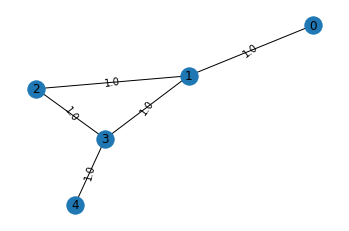

In [12]:

# Remplacement des valeurs infinies par 0, car networkx code 0 si l'arrête n'est pas présente
Bnetworkx = Btrop.copy()
Bnetworkx[np.where(Bnetworkx==np.inf)] = 0
# Création du graphe
G = nx.from_numpy_array(Bnetworkx)

# Pour faciliter l'affichage, création d'un attribut 'attraction' naturellement pris en compte dans nx.draw
weights = nx.get_edge_attributes(G, 'weight')
attraction = weights.copy()
for key in attraction:
    attraction[key] = weights[key]
nx.set_edge_attributes(G, attraction, name='attraction')
pos = nx.spring_layout(G,weight = 'attraction')

# Tracé du graphe
nx.draw_networkx_edge_labels(G, pos, edge_labels = weights)
nx.draw(G, pos, with_labels = True)

**_question 2_**

Calculer $B^2,B^3,B^4$ dans le contexte tropical, ainsi que les sommes partielles (vous pouvez également tracer les graphes associés). Que constatez vous ?

**Généralisations au cas pondéré**

Si $W = (W_{i,j})_{i,j}$ est la matrice d'adjacence du graphe pondéré $G$, c'est-à-dire
\begin{align*}
W_{i,j} = 
\begin{cases}
\text{la longueur de l'arrête entre $i$ et $j$} \\
+\infty~ \text{s'il n'y a pas d'arrête entre $i$ et $j$ dans $G$},
\end{cases}
\end{align*}
interpréter les coefficients de $W^{\otimes k}$. On pourra s'aider du graphe donné par la matrice $W$ suivante.

L'algorithme de calcul de distances de graphe associé s'appelle [l'agorithme de Floyd-Warshall](https://fr.wikipedia.org/wiki/Algorithme_de_Floyd-Warshall).




<div class= 'alert alert-block alert-info'>
<tt>    
  
<b>
Floyd–Warshall algorithm's pseudo-code (taken from wikipedia)    
</b> 

    
    
      function FloydWarshall_shortestpath(W):
    
        D=W 
        for k:=1 to n

            for i:=1 to n

                for j:=1 to n


                    D[i][j]:=min(D[i][j],D[i][k]+D[k][j])

                end for

            end for

        end for

     return D

</tt>    


</div>

**_question 1_**

Écrire une fonction `DistMatrice` prenant en entrée $W$ et calculant la matrice de distance de graphe associée.

In [13]:
def DistMatrice(W):
    C=ident_trop(n)

    return C



**_question 2_**

Appliquer cet algorithme au cas pondéré.

**_question 3_**

Estimer la complexité de cet algorithme

**_question 4_**

On rappelle les définitions :

l'**excentricité** d'un sommet est la distance max entre ce sommet et n'importe quel autre sommet de ce graphe.

$\xi(i) =  \max_j d_G(i,j) $


le **_diamètre_** est le max des excentricités 


$\delta = \max_i \max_j d_G(i,j) $

le **_radius_**  est le min des excentricités 

$\rho = \min_i \max_j d_G(i,j) $

En utilisant la multiplication tropicale, écrire les fonctions calculant la suite des excentricités, le diamètre et le rayon dans un graphe (éventuellement pondéré)


_attention : certaines valeurs peuvent être infinies! Elles seront représentées avec np.inf_

***
# <font color=blue>Demi-anneau booléen $(\{0,1\},\mathrm{OR},\mathrm{AND},0,1)$ et existence de chemins</font> #

Dans cette partie, nous utilisons le demi-anneau booléen.

**_question 0_**

Vérifier que $(\{0,1\},\mathrm{OR},\mathrm{AND},0,1)$ est un demi-anneau

**_question 1_**

Écrire une fonction qui calcule la multiplication matricielle dans ce demi-anneau.

In [33]:
def addbool(a,b):
    return (a or b)
                        
def mulbool(a,b):
    return (a and b)

#cette opération est déjà défini dans semiringMul, elle permet de définir ce que nous recherchons, il suffit jiste de changer les paramètres
def boolMul(A,B):
    """
     Calcule la multiplication de la matrice dans le demi-anneau booléen 
     (où l'addition est OU et la multiplication ET)

     :param A,B : Matrices booléennes
     :type A,B: Matrices booléennes (tableau numpy à deux dimensions)
     :return : la multiplication de matrice dans le booléen
     :rtype : une matrice booléenne (tableau numpy à deux dimensions)
     """
    return semiringMul(addbool,mulbool,A,B,0)

Si $A = (A_{i,j})_{i,j}$ est la matrice d'adjacence du graphe non-pondéré $G$, c'est-à-dire
\begin{align*}
A_{i,j} = 
\begin{cases}
True & \text{s'il y a une arrête entre $i$ et $j$ dans $G$} \\
False & \text{s'il n'y a pas d'arrête entre $i$ et $j$ dans $G$},
\end{cases}
\end{align*}

On représentera comme d'habitude $False = 0$ et $True = 1$


interpréter les coefficients de $A^{\otimes k}$.

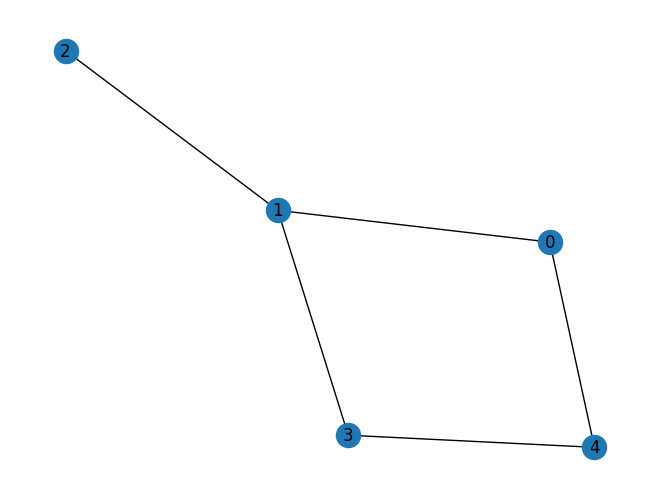

In [31]:
G = nx.from_numpy_array(A)
nx.draw(G, with_labels=True)

**_question 1_**

En utilisant la multiplication matricielle booléenne, ecrire une fonction calculant la matrice de distance de graphe _non pondéré_

_Attention : certaines valeurs peuvent être infinies ! L'infini sera représenté par `np.inf`_

In [45]:
def dist(A):
    """
     Calcule la distance entre i et j dans le graphe dont la matrice d'adjacence est A
     :param A: matrice d'adjacence (tableau numérique à deux dimensions)
     :type A: matrice (tableau numérique à deux dimensions) avec seulement 0 et 1
     :param i,j : sommets
     :type i,j : entiers
     :return : k, d(i,j)
     :rtype : entier ou np.inf
     """   
    n=A.shape[0]
    M = np.zeros((n,n))
    tmp = 0
    I,Aplus = np.identity(n),np.identity(n)
    condition = False
    while(condition != True or n<n):
        Aplus = boolMul(A,Aplus)
        for i in range(n):
            for j in range(n):
                if M[i,j] + I[i,j] != 0 and Aplus != 0:
                    M[i,j]=n   
        tmp+=1        
    return M
    
print(dist(A))

[[0 1 0 0 1]
 [1 0 1 1 0]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [1 0 0 1 0]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

**_question 2_** 


Écrire un algorithme calculant la _(cloture transitive)[https://en.wikipedia.org/wiki/Transitive_closure]_ d'un graphe (non-orienté)

**_question 3_** 

En déduire un algorithme calculant les composantes connexes d'un graphe
Écrire un algorithme calculant la _cloture transitive_ d'un graphe (non-orienté)

***
# <font color=blue>L'anneau classique $(\mathbb{N},+,\times,0,1)$ et multigraphes </font> #
***

Cet anneau permet de travailler avec des multi-graphes : $A_{i,j} \in \mathbb{N}$ encode le nombre d'arrêtes entre $i$ et $j$. Cette notion généralise donc les matrices d'adjacences classiques où $A_{i,j} \in \{0,1\}$.

Dans ce demi-anneau, $A_{i,j}^k$ compte le nombre de chemins de longueur exactement $k-1$ reliant $i$ à $j$ avec multiplicité.

Écrire une fonction calculant le nombre total de chemins de longueurs au plus $k$ entre tous les noeuds du graphe.

In [14]:
def path_total(A,k_max):
    n = A.shape[0]
    T = np.zeros((n,n))

    return T

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


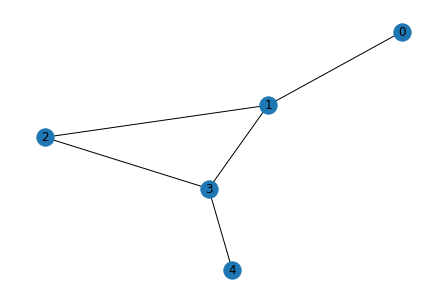

In [15]:
B=np.array(
[[0,1,0,0,0], 
[1,0,1,1,0], 
[0,1,0,1,0], 
[0,1,1,0,1],
[0,0,0,1,0]])

nx.draw(nx.from_numpy_array(B), with_labels = True)

print(path_total(B,3))

***
# <font color=blue> Demi-anneau bottleneck $(\mathbb{R}_+ \cup \{+\infty\},\max,\min,0,+\infty)$ et capacité </font> #
***

Vérifier que $(\mathbb{R}_+ \cup \{+\infty\},\max,\min,0,+\infty)$ est un demi-anneau.

Dans ce demi-anneau, la puissance des matrices possède l'interprétation capacitique suivante :

Suposons que $W_{i,j}$ correspond au flux (ou à la capacité) admissible par l'arrête $(i,j)$ dans le graphe $G$, de sorte que $W_{i,j} = 0$ correspond à l'absence d'arrête, c'est-à-dire à un flux admissible nul. Pour tout chemin sur $G$, on définit sa capacité comme le minimum des capacité des arrêtes qui le composent.
Alors $W^{\otimes k}_{i,j}$ correspond à la capacité maximale d'un chemin entre $i$ et $j$ passant par au plus $k-1$ noeuds intermédiaires.

Exemples :

- Pour un réseau routier, $W_{i,j}$ peut modéliser le poids maximum que la route $i \to j$ supporte (ex. 3,5T, 12T, etc.), alors $W^{\otimes k}_{i,j}$ correspond à la plus faible capacité par laquelle on doit passer pour relier $i$ à $j$ en au plus $k-1$ étapes.
- Pour un réseau électrique, $W_{i,j}$ peut modéliser une conductance. Le chemin implictement calculé par $W^{\otimes k}_{i,j}$ décrit alors par où l'électricité rencontre le moins de résistance pour aller de $i$ à $j$ en au plus $k-1$ composants.

***
# <font color=blue> Bonus : excentricités</font> #
***


On a vu dans le TP1 une manière de vérifier si une suite est _graphique_ (voir de construire le graphe associé).

Un théorème permet de  faire (presque) la même chose pour l'ensemble des excentricité. Lire https://www.sciencedirect.com/science/article/pii/0012365X76900984 et construire l'algorithme associé